# Lab 4: Spam Classifier on Ingested Data
##### ML Productions
##### Dr. Nowling

## Library Import

In [2]:
import glob
import json
import numpy as np
import os
import pandas as pd
import boto3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Importing Data

The data type of each colum is an object since each colum is comprised of string objects.

In [2]:
target = boto3.resource('s3',
    endpoint_url=os.environ['MINIO_URL'],
    aws_access_key_id=os.environ['MINIO_ID'],
    aws_secret_access_key=os.environ['MINIO_PASSWORD'],
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False
)

In [3]:
jsons = []
for file in files:
    filepath = file
    f = open(filepath,)
    jsons.append(json.load(f))
dataframe = pd.DataFrame.from_records(jsons)
print(dataframe.dtypes)

label           object
to_address      object
from_address    object
subject         object
body            object
dtype: object


## Transforming Data for Predictions
### Count Vectorizer

In [14]:
vectorizer = CountVectorizer(min_df=10)
X = vectorizer.fit_transform(dataframe['body'].to_numpy())
print('Size of the array', X.shape)
print('Columns', X.shape[1])

Size of the array (63542, 32144)
Columns 32144


In [20]:
print('Total Elements', X.shape[0]*X.shape[1])
print('Number of Non-zero elements', np.count_nonzero(np.array(X.toarray())))

Total Elements 2042494048
Number of Non-zero elements 6388757


### Dimensionality Reduction

#### Clustering the Email

In [5]:
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

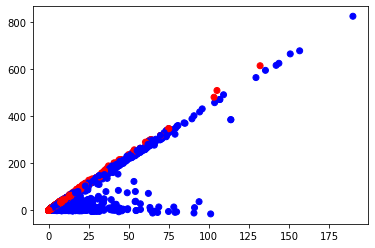

In [6]:
colors = dataframe['label'].to_numpy().copy()
colors[colors=='ham'] = 'blue'
colors[colors=='spam'] = 'red'


x_axis = X_reduced[:,0]
y_axis = X_reduced[:,1]

true_label = x_axis<200

x_axis = x_axis[true_label]
y_axis = y_axis[true_label]

colors = colors[true_label]

plt.scatter(x_axis, y_axis, c=colors)
plt.show()

#### Finding the Correct Amount of Dimensions

I set the max iterations to 300 to avoid convergence warnings.

In [24]:
recalls=[]
precisions=[]
accuracies=[]
y = dataframe['label'].to_numpy()
component_range = range(1,20)

for i in component_range:
    svd = TruncatedSVD(n_components=i)
    X_reduced = svd.fit_transform(X)
    logreg = LogisticRegression(max_iter=300) 
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=0)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_val)
    matrix = confusion_matrix(y_val, y_pred)
    tp = matrix[1][1]
    tn = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    
    precisions.append((tp)/(tp+fp))
    accuracies.append((tp+tn)/(tp+tn+fn+fp))
    recalls.append((tp)/(tp+fn))

Looking at the graphs below it seems that the optimum number of components is 8. After this point the model appears to have diminishing returns.

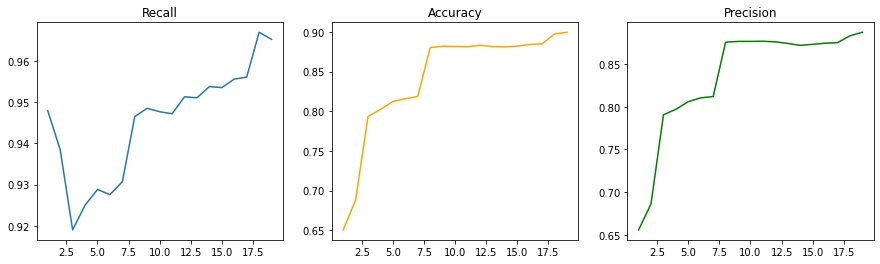

In [23]:
figure, axis = plt.subplots(1,3)
figure.set_figwidth(15)

axis[0].plot(component_range, recalls, label='Recall Score')
axis[0].set_title('Recall')
axis[1].plot(component_range, accuracies, label='Accuracy Score', color='orange')
axis[1].set_title('Accuracy')
axis[2].plot(component_range, precisions, label='Precision Score', color='green')
axis[2].set_title('Precision')
plt.show()

## Making Predictions

### Downsampling the larger class

I will be downsampling after the train test split to avoid data leakage. As noted in this [Medium article](https://towardsdatascience.com/heres-what-i-ve-learnt-about-sklearn-resample-ab735ae1abc4).

#### Train Test Split

In [25]:
svd = TruncatedSVD(n_components=8)
X_reduced = svd.fit_transform(X)
y = dataframe['label'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.3, stratify=y)

#### Resampling

I am using the downsampling technique shown on [Chris Albon's site](https://chrisalbon.com/code/machine_learning/preprocessing_structured_data/handling_imbalanced_classes_with_downsampling/).

The larger class is the spam class, so I will reduce the spam class to match the ham class.

In [31]:
i_ham = np.where(y_train=='ham')[0]
i_spam = np.where(y_train=='spam')[0]

n_ham = len(i_ham)
n_spam = len(i_spam)

print(n_ham)
print(n_spam)

16164
28315


In [33]:
i_spam_downsampled = np.random.choice(i_spam, size=n_ham, replace=False)
print(len(i_spam_downsampled))

16164


In [46]:
y_downsampled = np.hstack((y_train[i_ham], y_train[i_spam_downsampled]))
X_downsampled = np.vstack((X_train[i_ham], X_train[i_spam_downsampled]))

print(y_downsampled.shape)
print(X_downsampled.shape)

(32328,)
(32328, 8)


### Logistic Regression

In [41]:
logreg = LogisticRegression()  

logreg.fit(X_downsampled, y_downsampled)

LogisticRegression()

## Model Analysis

### ROC Curve

In [42]:
prob = logreg.predict_proba(X_val)
y_pred_prob = prob[:,1]
print(y_pred_prob.shape)
print(np.unique(y_val))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label='spam')

(19063,)
['ham' 'spam']


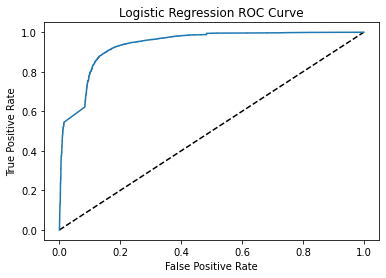

In [43]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logisitc Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

### Confusion Matrix

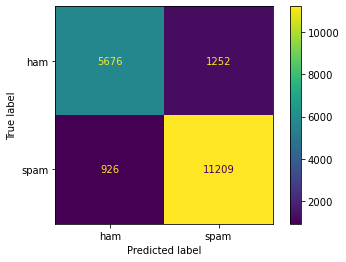

In [44]:
plot_confusion_matrix(logreg, X_val, y_val)

### Accuracy, Recall, Precison

In [45]:
y_pred = logreg.predict(X_val)
matrix = confusion_matrix(y_val, y_pred)
tp = matrix[1][1]
tn = matrix[0][0]
fp = matrix[0][1]
fn = matrix[1][0]

print('Accuracy:', (tp+tn)/(tp+tn+fn+fp))
print('Precision:', (tp)/(tp+fp))
print('Recall:', (tp)/(tp+fn))

Accuracy: 0.8857472590882862
Precision: 0.8995265227509831
Recall: 0.9236918005768439
